In [1]:
# 必要なライブラリを読み込む
import numpy as np
import matplotlib.pyplot as plt

# 必要な関数を読み込む
from sklearn import datasets
from sklearn.neighbors import NearestNeighbors

# Jupyter 上で図を表示するためのコマンド
%matplotlib inline

In [2]:
data = np.loadtxt("data/chfdb_chf13_45590.txt", delimiter="\t")

print(data.shape)
train_data = data[:2000, 2]
test_data = data[2001:, 2]

(3750, 3)


(2000,)


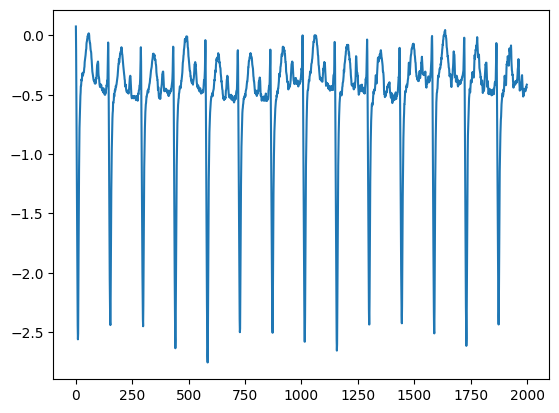

(1749,)


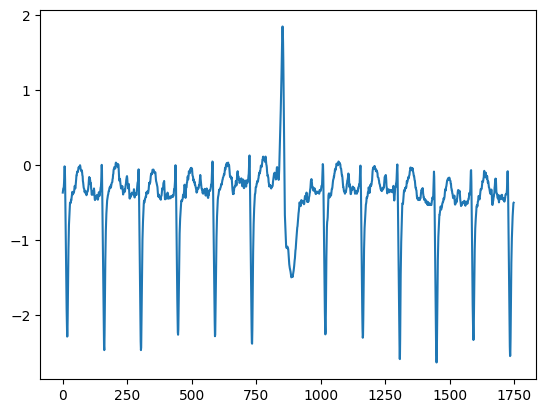

In [3]:
print(train_data.shape)
plt.plot(train_data)
plt.show();

print(test_data.shape)
plt.plot(test_data)
plt.show();

#### スライド窓を切り出して、特徴量をつくる

In [4]:
def convert_into_vector(data, M):
    '''ウィンドウを用いて新たな特徴量を作成する
    
    Args:
            data (np.ndarray): 変換したいデータ
            M (int): ウィンドウ幅
            
    Returns:
            data_to_vector (np.ndarray): ベクトルの特徴量をもつデータ
    '''
    
    data_size = len(data) - M + 1
    # ウィンドウによって時系列データをベクトルに変換
    data_to_vector = np.empty([data_size, M], float)

    for i in range(data_size):
        data_to_vector[i,] = data[i:i+M]
    
    return data_to_vector

In [5]:
# スライド幅の窓
M = 100

train_vector = convert_into_vector(train_data, M)
print(train_data.shape)
print(train_vector.shape)
print(train_vector)

(2000,)
(1901, 100)
[[ 0.075 -0.13  -0.47  ... -0.225 -0.22  -0.24 ]
 [-0.13  -0.47  -0.855 ... -0.22  -0.24  -0.32 ]
 [-0.47  -0.855 -1.21  ... -0.24  -0.32  -0.345]
 ...
 [-0.455 -0.4   -0.375 ... -0.44  -0.435 -0.445]
 [-0.4   -0.375 -0.34  ... -0.435 -0.445 -0.42 ]
 [-0.375 -0.34  -0.36  ... -0.445 -0.42  -0.415]]


In [6]:
test_vector = convert_into_vector(test_data, M)

#### 異常度の算出

In [7]:
# サンプルごとの異常度を計算
def calculate_knn_abnormality(data_vector, train_vector, k, is_train=True):
    '''
    Args:
            data_to_vector (np.ndarray): 異常度を計算するデータ
            train_to_vector (np.ndarray): 学習データ (特徴量作成済み)
            k (int): 近傍点の数
            is_train (boolean): 学習かどうか
            
    Returns:
            abnormarity (np.ndarray): 異常度
    '''
    
    # 次元数を格納
    M = data_vector.shape[1]
    
    # 一番目はそのサンプル自身なので、train自体の異常度計算時は2番目からkとして扱う
    if is_train:
        k = k + 1
    
    # 学習(正常データを指定)
    neigh = NearestNeighbors(n_neighbors=k, metric='euclidean')
    neigh.fit(train_vector)
    
    # 異常度を計算したいデータまでの距離とインデックスを算出
    epsilon, indices = neigh.kneighbors(data_vector, return_distance=True)
    
    # k点目の近傍点までの距離を異常度の計算に用いる
    epsilon = epsilon[:, k-1]
    abnormality = -np.log(k) + M * np.log(epsilon)
    
    return abnormality


In [8]:
k = 1
train_abnormality = calculate_knn_abnormality(train_vector, train_vector, k, is_train = True)
test_abnormality = calculate_knn_abnormality(test_vector, train_vector, k, is_train = False)

print(train_abnormality)
print(test_abnormality)

[ -71.835878    -71.48445537  -70.97210331 ... -117.61671576 -118.98270563
 -118.98270563]
[-30.99483594 -30.96696267 -30.78847798 ... -52.38764192 -52.54828176
 -52.60910249]


In [9]:
# 閾値の設定
upper = train_abnormality.max()
lower = test_abnormality.min()
tr_width = upper - lower
margin = 0.05

threshold = train_abnormality.max() + margin * tr_width 

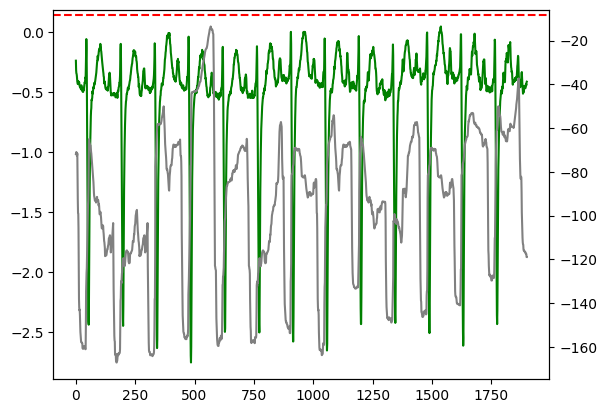

In [10]:
# trainデータと異常度の描画

# 異常と判定した部分を破線で示す
fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)
ax1.grid(False)

# ax1とax2を関連させる
ax2 = ax1.twinx()

# ax1.plot(train_data[0:len(train_abnormality)], color="green")
ax1.plot(train_data[M-1:], color="green")
ax2.plot(train_abnormality, color="gray")
ax2.axhline(threshold, ls="--", color="red")

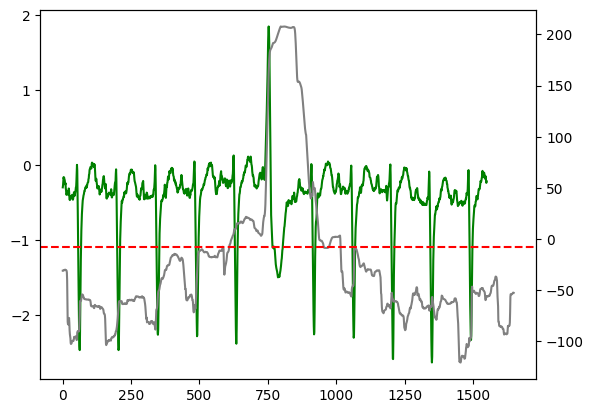

In [11]:
# testデータと異常度の描画

# 異常と判定した部分を破線で示す
fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)
ax1.grid(False)

# ax1とax2を関連させる
ax2 = ax1.twinx()

# ax1.plot(test_data[0:len(test_abnormality)], color="green")
ax1.plot(test_data[M-1:len(test_abnormality)], color="green")
ax2.plot(test_abnormality, color="gray")
ax2.axhline(threshold, ls="--", color="red")